In [1]:
import os
os.environ['MXNET_ENGINE_TYPE'] = 'NaiveEngine'
#os.environ['MXNET_CUDNN_AUTOTUNE_DEFAULT'] = '1'

import pandas as pd
import numpy as np
from sklearn.utils import shuffle
import mxnet as mx
from mxnet import gluon
from mxnet.gluon import nn
from mxnet.image import color_normalize
import mxnet.autograd as autograd
from mxnet.gluon.model_zoo import vision as models
from tqdm import tqdm

In [2]:
#더미 파일 리스트를 구축한다. , im2rec.py는 https://github.com/apache/incubator-mxnet/blob/master/tools/im2rec.py 
%run im2rec.py --list list catsdogs_full train

In [3]:
#아래 보는것과 같이 텝으로 구분되어서 파일 인덱스, 레이블(클래스), 사진파일명 정보가 구성된다. 
!head catsdogs_full.lst

3197	0.000000	cat.1625.jpg
15084	0.000000	dog.12322.jpg
1479	0.000000	cat.11328.jpg
5262	0.000000	cat.3484.jpg
20714	0.000000	dog.6140.jpg
9960	0.000000	cat.7712.jpg
945	0.000000	cat.10848.jpg
15585	0.000000	dog.1524.jpg
12376	0.000000	cat.9888.jpg
4367	0.000000	cat.2679.jpg


In [4]:
#pandas 테이블로 파일을 읽어들여 레이블을 마킹하고 랜덤 셔플한 뒤 학습과 테스트셋으로 만든다. 
catdoglist = pd.read_csv('catsdogs_full.lst',sep='\t', names=['idx', 'class', 'fn'])

catdoglist['class'] = [1  if i else 0 for i in catdoglist['fn'].str.contains('dog')]

catdoglist = shuffle(catdoglist)

train = catdoglist.iloc[:650, ]#catdoglist.iloc[:6500, ]

train.shape

test = catdoglist.iloc[650:, ]#catdoglist.iloc[6500:, ]

train.to_csv('catsdogs_train.lst',doublequote=False,sep='\t', header=False, index=False)
test.to_csv('catsdogs_test.lst',doublequote=False,sep='\t', header=False, index=False)

In [5]:
#실제 Image RecordIO dataset을 만든다. 
!python im2rec.py --num-thread 10 catsdogs_t train

Creating .rec file from /home/hyungjunkim/Dropbox/repo/dl/gluon/Convolution/catsdogs_test.lst in /home/hyungjunkim/Dropbox/repo/dl/gluon/Convolution
time: 0.1306004524230957  count: 0
time: 0.5677025318145752  count: 1000
time: 0.546433687210083  count: 2000
time: 0.47595953941345215  count: 3000
time: 0.3755829334259033  count: 4000
time: 0.6438181400299072  count: 5000
time: 0.8235001564025879  count: 6000
time: 0.528831958770752  count: 7000
time: 0.45096564292907715  count: 8000
time: 0.4435310363769531  count: 9000
time: 0.4778022766113281  count: 10000
time: 0.3157036304473877  count: 11000
time: 0.3254568576812744  count: 12000
time: 0.41601061820983887  count: 13000
time: 0.6791329383850098  count: 14000
time: 0.44155216217041016  count: 15000
time: 0.7316668033599854  count: 16000
time: 0.408724308013916  count: 17000
time: 0.2872886657714844  count: 18000
time: 0.3322420120239258  count: 19000
time: 0.28879737854003906  count: 20000
time: 0.25882458686828613  count: 21000
tim

#### 모형 생성 

In [6]:
class cats_and_dogs(gluon.HybridBlock):
    def __init__(self, num_class, num_hidden , **kwargs):
        super(cats_and_dogs, self).__init__(**kwargs)
        
        with self.name_scope():
            #model zoo에서 vgg16 모형을 가져온다. 
            #이렇게 vgg를 클래스 내부에서 로딩하면 인스턴스마다 context, prefix 가 통일되게 생성되어 모형 저장/로딩시 용이한 측면이 있다.  
            vgg_net =  models.vgg16(pretrained=True, root=".models").features
            self.features = nn.HybridSequential()
            for i in vgg_net[:31]:
                self.features.add(i)
            self.conv2d = nn.Conv2D(1024, kernel_size=(3,3), activation ='relu')
            self.glob_avg_pool = nn.GlobalAvgPool2D()
            self.dense = nn.Dense(units=num_class)        
    
    def hybrid_forward(self, F, inputs, grad=False):
        inputs.attach_grad()
        o_vgg = self.features(inputs)
        conv2d = self.conv2d(o_vgg)
        gap = self.glob_avg_pool(conv2d)
        gap_re = F.reshape(gap, (-1, 1024))
        pred = self.dense(gap_re)
        if grad:
            return pred, conv2d, inputs
        else:
            return pred
    
    def get_conv(self, F, inputs):
        o_vgg = self.features(inputs)
        conv2d = self.conv2d(o_vgg)
        return conv2d
 

In [7]:
model = cats_and_dogs(num_class=2, num_hidden = 500)

In [8]:
test_d = mx.nd.random.normal(0,1, (1,3, 224, 224), ctx=mx.cpu(0))
model.collect_params().initialize(mx.init.Xavier(), ctx=mx.cpu(0))
model(test_d)

/home/hyungjunkim/python/venv/dl/lib/python3.5/site-packages/mxnet/gluon/parameter.py:320: UserWarning: Parameter cats_and_dogs0_vgg0_conv0_weight is already initialized, ignoring. Set force_reinit=True to re-initialize.
  "Set force_reinit=True to re-initialize."%self.name)
/home/hyungjunkim/python/venv/dl/lib/python3.5/site-packages/mxnet/gluon/parameter.py:320: UserWarning: Parameter cats_and_dogs0_vgg0_conv0_bias is already initialized, ignoring. Set force_reinit=True to re-initialize.
  "Set force_reinit=True to re-initialize."%self.name)
/home/hyungjunkim/python/venv/dl/lib/python3.5/site-packages/mxnet/gluon/parameter.py:320: UserWarning: Parameter cats_and_dogs0_vgg0_conv1_weight is already initialized, ignoring. Set force_reinit=True to re-initialize.
  "Set force_reinit=True to re-initialize."%self.name)
/home/hyungjunkim/python/venv/dl/lib/python3.5/site-packages/mxnet/gluon/parameter.py:320: UserWarning: Parameter cats_and_dogs0_vgg0_conv1_bias is already initialized, ignor


[[-0.08207104 -0.01866993]]
<NDArray 1x2 @cpu(0)>

In [9]:
### Symbolic 텐서로 컴파일한다. 
#확실히 GPU메모리 사용량은 줄어드나, 학습 속도가 2배 넘게 빨리지지는 않는거 같다. 
#model.hybridize()

In [10]:
print(model)

cats_and_dogs(
  (conv2d): Conv2D(512 -> 1024, kernel_size=(3, 3), stride=(1, 1))
  (dense): Dense(1024 -> 2, linear)
  (glob_avg_pool): GlobalAvgPool2D(size=(1, 1), stride=(1, 1), padding=(0, 0), ceil_mode=True)
  (features): HybridSequential(
    (0): Conv2D(3 -> 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Activation(relu)
    (2): Conv2D(64 -> 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): Activation(relu)
    (4): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False)
    (5): Conv2D(64 -> 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): Activation(relu)
    (7): Conv2D(128 -> 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): Activation(relu)
    (9): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False)
    (10): Conv2D(128 -> 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): Activation(relu)
    (12): Conv2D(256 -> 256, kernel_size=(3, 3), stride=(1, 1), padding=(1

#### 학습

In [11]:
#생성한 rec 파일로 이터레이터를 생성한다. 
#Tensorflow와 케라스에서와는 다르게 채널이 먼저 나온다.
#이미지 학습을 하는데 ImageRecordIter는 거의 필수라고 생각하는데, 이는 다양한 data augmentation의 옵션을 제공하기 때문이다.
batch_size = 20  # 멀티 GPU인 관계로 더 많은 배치를 할당해본다. 
valid_batch_size = 20 #validation은 적어도 큰 문제가 없다. 
train_iter = mx.io.ImageRecordIter(path_imgrec='catsdogs_train.rec',
                                   min_img_size=256,
                                   data_shape=(3, 224, 224),
                                   rand_crop=True,
                                   shuffle=True,
                                   batch_size=batch_size,
                                   max_random_scale=1.5,
                                   min_random_scale=0.75,
                                   rand_mirror=True)
val_iter = mx.io.ImageRecordIter(path_imgrec="catsdogs_test.rec",
                                 min_img_size=256,
                                 data_shape=(3, 224, 224),
                                 batch_size=valid_batch_size)

In [12]:
def evaluate(net, data_iter, ctx):
    data_iter.reset()
    acc = mx.metric.Accuracy()
    for batch in data_iter:
        mx.nd.waitall()
        #reference 
        #https://mxnet.incubator.apache.org/api/python/gluon/model_zoo.html
        data = color_normalize(batch.data[0]/255,
                               mean=mx.nd.array([0.485, 0.456, 0.406]).reshape((1,3,1,1)),
                               std=mx.nd.array([0.229, 0.224, 0.225]).reshape((1,3,1,1)))
        data = gluon.utils.split_and_load(data, ctx)
        label = gluon.utils.split_and_load(batch.label[0], ctx)

        with autograd.predict_mode():
            for X, Y in zip(data, label):
                output = net(X)
                predictions = mx.nd.argmax(output, axis=1)
                acc.update(preds=predictions, labels=Y)
                mx.ndarray.waitall()
    return acc.get()[1]


In [13]:
from mxnet.gluon import nn, Block, HybridBlock, Parameter, ParameterDict

In [14]:
import mxnet.autograd as autograd
from mxnet import gluon
import logging
import os
import time
import numpy as np
logging.basicConfig(level=logging.INFO)

    
GPU_COUNT = 1 # increase if you have more

def train(net, train_iter, val_iter, epochs, ctx= [mx.gpu(i) for i in range(GPU_COUNT)], need_init=False):
    
    if need_init:
        #vgg16 모형은 학습을 fix 한다. 
        # https://github.com/apache/incubator-mxnet/issues/1340
        net.features.collect_params().setattr('grad_req', 'null')
        net.conv2d.collect_params().initialize(mx.init.Xavier(), ctx=ctx)
        net.glob_avg_pool.collect_params().initialize(mx.init.Xavier(), ctx=ctx)
        net.dense.collect_params().initialize(mx.init.Xavier(), ctx=ctx)
        
    #변수들이 모두 같은 ctx에 있는지 다시 확인 
    net.collect_params().reset_ctx(ctx)

    trainer = gluon.trainer.Trainer(net.collect_params(), 'rmsprop', optimizer_params={'learning_rate':0.001})
    loss = gluon.loss.SoftmaxCrossEntropyLoss(sparse_label=False)

    val_accs = evaluate(net, val_iter, ctx)
    logging.info('[Initial] validation accuracy : {}'.format(val_accs))
    tr_loss = []
    val_accs = []
    for epoch in range(epochs):
        tic = time.time()
        train_iter.reset()
        btic = time.time()
        loss_seq = []
        for i, batch in enumerate(tqdm(train_iter)):
            batch_rec =batch.data[0].shape[0]
            data = color_normalize(batch.data[0]/255,
                                   mean=mx.nd.array([0.485, 0.456, 0.406]).reshape((1,3,1,1)),
                                   std=mx.nd.array([0.229, 0.224, 0.225]).reshape((1,3,1,1)))
            data = gluon.utils.split_and_load(data, ctx)
            label = gluon.utils.split_and_load(mx.nd.one_hot(batch.label[0], 2), ctx)
            
            with autograd.record():
                losses = [loss(net(X), Y) for X, Y in zip(data, label)]
                for l in losses:
                    l.backward()
            #속도를 좀 감소시키더라도 GPU 메모리에 대한 관리를 더 한다.  
            mx.ndarray.waitall()
            trainer.step(batch_rec)
            btic = time.time()
            curr_loss = mx.nd.mean(l).asscalar()
            loss_seq.append(curr_loss)
        logging.info('[Epoch {}] training loss : {}'.format(epoch, np.mean(loss_seq)))
        logging.info('[Epoch %d] time cost: %f'%(epoch, time.time()-tic))
        val_acc = evaluate(net, val_iter, ctx)
        logging.info('[Epoch %d] validation accuracy : %s'%(epoch, val_acc))
        val_accs.append(val_acc)
        tr_loss.append(np.mean(loss_seq))
    return(val_accs, tr_loss)

accs, losses = train(model,train_iter, val_iter, epochs=1, ctx=[mx.gpu(i) for i in range(GPU_COUNT)], need_init=True)

model.save_params("trained_mdl.params")

In [15]:
model.collect_params().initialize(mx.init.Xavier(), ctx=mx.cpu(0), force_reinit=True)

In [16]:
#cpu에서 동작 시킨다.  
model.collect_params().reset_ctx(mx.cpu(0))

In [17]:
model.load_params("trained_mdl.params", ctx=mx.cpu(0))

#### 분류 예제 

In [18]:
from skimage.color import rgba2rgb
from skimage import io
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import cv2
%matplotlib inline

def get_cam(in_img, org_img, net, cls_idx):
    act_weights = net.dense.weight.data().asnumpy()
    conv_out = net.get_conv(F=mx.nd, inputs=in_img).asnumpy().squeeze()
    #512개의 필터에 대한 가중치(class activation)를 곱해서 sum을 한다. 

    cam = np.zeros(dtype=np.float32, shape=conv_out.shape[1:3])
    for k, w in enumerate(act_weights[cls_idx, :]):
        cam += w * conv_out[k, :, :]

    cam_norm = cam / np.max(cam)
       
    resized_cam = cv2.resize(cam_norm, (224, 224))
    
    resized_cam = np.uint8(255 * resized_cam)

    heatmap = cv2.applyColorMap(resized_cam, cv2.COLORMAP_JET)
    
    heatmap = np.transpose(heatmap, (1,0,2))

    cat_img_np = org_img.asnumpy()

    superimposed_img = heatmap * 0.3 + cat_img_np
    
    cv2.imwrite('cam_apply.jpg', superimposed_img)
    img=mpimg.imread('cam_apply.jpg')
    cv2.imwrite('grad_cam_apply.jpg', heatmap)
    heatmap=mpimg.imread('grad_cam_apply.jpg')
    return img, heatmap, cam_norm

In [19]:
def get_grad_cam(in_img, org_img, net, cls_idx):
    loss = gluon.loss.SoftmaxCrossEntropyLoss()
    
    with autograd.record():
        output, acts, _ = net.hybrid_forward(F=mx.nd, inputs=in_img, grad=True)
        loss_ = loss(output, mx.nd.array([[1 if cls_idx == 0 else 0,]],ctx=mx.cpu(0)).astype('float32'))
    loss_.backward()

    acts = acts.asnumpy().squeeze()    
    pooled_grad = mx.nd.mean(net.conv2d.weight.grad(), axis=(1,2,3)).asnumpy()
    
    for i in range(pooled_grad.shape[0]):
        acts[i,:,:] *= pooled_grad[i]
    
    cam = np.mean(acts, axis=0)
    
    cam_norm = cam / np.max(cam)
    
    resized_cam = cv2.resize(cam_norm, (224, 224))
    resized_cam = np.uint8(255 * resized_cam)
    
    heatmap = cv2.applyColorMap(resized_cam, cv2.COLORMAP_JET)
    
    heatmap = np.transpose(heatmap, (1,0,2))

    cat_img_np = org_img.asnumpy()

    superimposed_img = heatmap * 0.3 + cat_img_np

    cv2.imwrite('grad_cam_apply.jpg', superimposed_img)
    img=mpimg.imread('grad_cam_apply.jpg')
    
    cv2.imwrite('grad_cam_apply.jpg', heatmap)
    heatmap=mpimg.imread('grad_cam_apply.jpg')
    return img, heatmap 

In [45]:
#reference : http://gluon.mxnet.io/chapter08_computer-vision/fine-tuning.html
def classify_dogcat_and_cam(net, url, grad_iter):
    plt.figure(figsize=(15, 20))
    I = io.imread(url)
    if I.shape[2] == 4:
        I = rgba2rgb(I)
    image = mx.nd.array(I).astype(np.uint8)
    plt.subplot(6, 2, 1)
    plt.title("orignal") 
    plt.imshow(image.asnumpy())
    image = mx.image.resize_short(image, 256)
    image, _ = mx.image.center_crop(image, (224, 224))
    plt.subplot(6, 2, 2)
    plt.title("input") 
    org_img = image
    plt.imshow(org_img.asnumpy())
    image = mx.image.color_normalize(image.astype(np.float32)/255,
                                     mean=mx.nd.array([0.485, 0.456, 0.406]),
                                     std=mx.nd.array([0.229, 0.224, 0.225]))
    image = mx.nd.transpose(image.astype('float32'), (2,1,0))
    image = mx.nd.expand_dims(image, axis=0)
    in_img = image
    out = mx.nd.SoftmaxActivation(net(in_img))
    print('Probabilities are: '+str(out[0].asnumpy()))
    result = np.argmax(out.asnumpy())
    outstring = ['cat!', 'dog!']
    
    imposed_img, heatmap, cam_norm = get_cam(in_img, org_img, net, result)
    plt.subplot(6, 2, 3)
    plt.title("CAM heatmap") 
    plt.imshow(heatmap)
    plt.subplot(6, 2, 4)
    plt.title("Superimposed")
    plt.imshow(imposed_img)
    
    imposed_img, heatmap = get_grad_cam(in_img, org_img, net, result)
    plt.subplot(6, 2, 5)
    plt.title("Grad CAM heatmap") 
    plt.imshow(heatmap)
    plt.subplot(6, 2, 6)
    plt.title("Superimposed")
    plt.imshow(imposed_img)
    
    imposed_img, heatmap, _ = get_inte_grad(in_img, org_img, net, result, grad_iter=0)
    plt.subplot(6, 2, 7)
    plt.title("Gradient heatmap") 
    plt.imshow(heatmap)
    plt.subplot(6, 2, 8)
    plt.title("Superimposed")
    plt.imshow(imposed_img)
    
    imposed_img, heatmap, acts_array = get_inte_grad(in_img, org_img, net, result, grad_iter)
    plt.subplot(6, 2, 9)
    plt.title("Integrated-Gradients heatmap") 
    plt.imshow(heatmap)
    plt.subplot(6, 2, 10)
    plt.title("Superimposed")
    plt.imshow(imposed_img)

    #imposed_img, heatmap, _ = get_inte_grad2(in_img, org_img, net, result, grad_iter)
    #plt.subplot(6, 2, 11)
    #plt.title("Integrated-Gradients2 heatmap") 
    #plt.imshow(heatmap)
    #plt.subplot(6, 2, 12)
    #plt.title("Superimposed")
    #plt.imshow(imposed_img)
    #return acts_array, in_img, cam_norm

In [68]:
def get_inte_grad(in_img, org_img, net, cls_idx, grad_iter=10):
    loss = gluon.loss.SoftmaxCrossEntropyLoss(sparse_label=True, weight=0.1)
    
    reference = mx.nd.zeros(in_img.shape)
    
    if grad_iter == 0:
        scaled_images = in_img
        label = [[1 if cls_idx == 0 else 0,]]
    else:
        scaled_images = (float(1)/(grad_iter*10))*in_img
        for i in range(2, grad_iter+1):
            scaled_images = mx.nd.concatenate([scaled_images, (float(i)/(grad_iter*10)*in_img)])
        label = [[1 if cls_idx == 0 else 0,] for i in range(grad_iter)]
                
    with autograd.record():
        output, acts, grads = net.hybrid_forward(F=mx.nd, inputs=scaled_images, grad=True)
        label = mx.nd.array(label ,ctx=mx.cpu(0)).astype('float32')
        loss_ = loss(output, label)
    loss_.backward()
        
    acts_array = grads.grad.asnumpy()
    
    cam = np.average(acts_array, axis=0)
    cam = cam / np.max(cam)
    
    ptile = 99
    h = np.percentile(cam, ptile)
    l = np.percentile(cam, 100-ptile)
    cam_norm = np.clip(cam/max(abs(h), abs(l)), -1.0, 1.0)    
    
    cam_norm = np.transpose(cam_norm, (2,1,0))
    
    resized_cam = cv2.resize(cam_norm, (224, 224))
    
    #http://opencv-python.readthedocs.io/en/latest/doc/08.imageProcessing/imageProcessing.html
    R=np.array([1,0,0])
    G=np.array([0,1,0])
    B=np.array([0,0,1])
        
    pos_attrs = resized_cam * (resized_cam >= 0.0)
    neg_attrs = -1.0 * resized_cam * (resized_cam < 0.0)
    resized_cam = pos_attrs*G + neg_attrs*R
    
    resized_cam = np.uint8(255 * resized_cam)
    
    heatmap = cv2.applyColorMap(resized_cam, cv2.COLORMAP_JET)
           
    cat_img_np = org_img.asnumpy()

    superimposed_img = heatmap * 0.5 + cat_img_np 

    cv2.imwrite('grad_cam_apply.jpg', superimposed_img)
    img=mpimg.imread('grad_cam_apply.jpg')
    
    cv2.imwrite('grad_cam_apply.jpg', heatmap)
    heatmap=mpimg.imread('grad_cam_apply.jpg')
    return img, heatmap, acts_array

Probabilities are: [ 1.  0.]


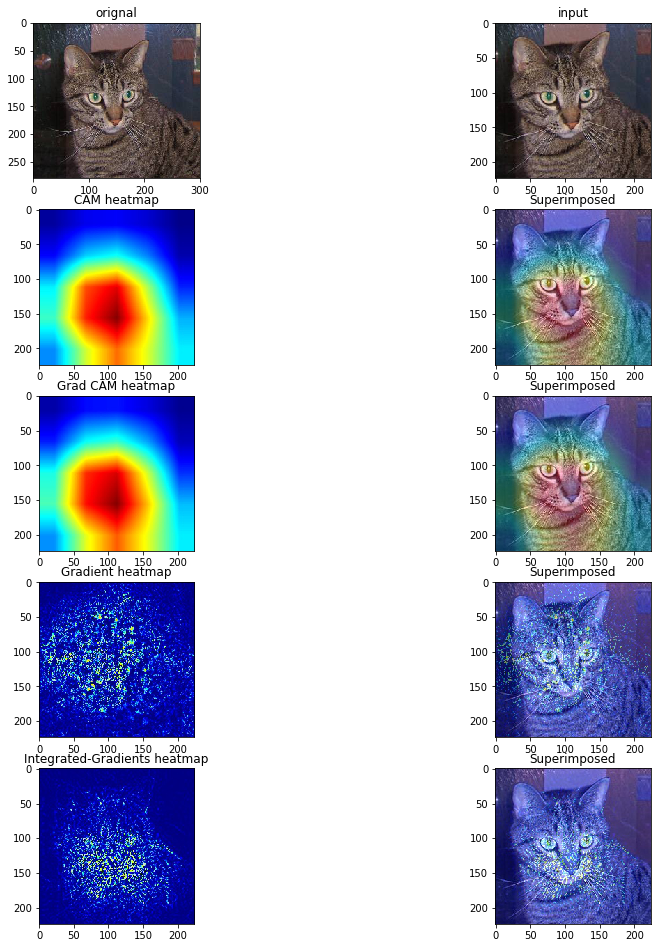

In [69]:
classify_dogcat_and_cam(net=model, url="train/cat.1.jpg", grad_iter=10)

Probabilities are: [  1.00000000e+00   4.81602563e-15]


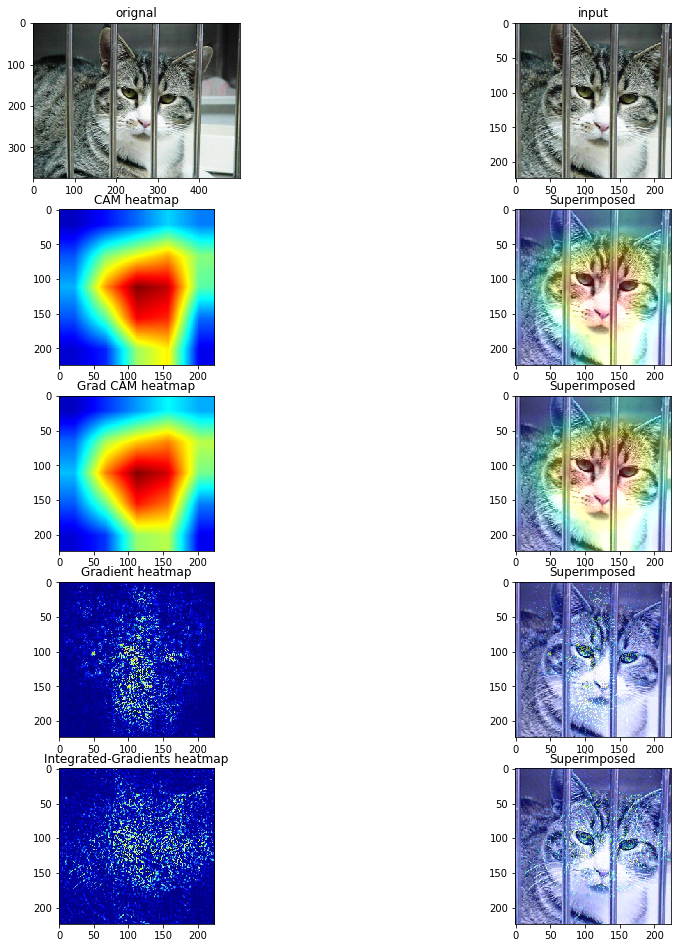

In [70]:
classify_dogcat_and_cam(net=model, url="train/cat.17.jpg", grad_iter=10)

In [ ]:
def get_inte_grad2(in_img, org_img, net, cls_idx, grad_iter=10):
    loss = gluon.loss.SoftmaxCrossEntropyLoss(sparse_label=True, weight=0.1)
    
    reference = mx.nd.zeros(in_img.shape)
    
    if grad_iter == 0:
        scaled_images = in_img
        label = [[1 if cls_idx == 0 else 0,]]
    else:
        scaled_images = (float(1)/(grad_iter))*in_img*1/50
        for i in range(2, grad_iter+1):
            scaled_images = mx.nd.concatenate([scaled_images, (float(i)/(grad_iter))*in_img*1/50])
        label = [[1 if cls_idx == 0 else 0,] for i in range(grad_iter)]
                
    with autograd.record():
        output, acts, grads = net.hybrid_forward(F=mx.nd, inputs=scaled_images, grad=True)
        label = mx.nd.array(label ,ctx=mx.cpu(0)).astype('float32')
        loss_ = loss(output, label)
    loss_.backward()
        
    acts_array = grads.grad.asnumpy()
   
    reference = np.zeros(acts_array[0].shape)
    num_steps = np.shape(acts_array)[0]
    ret = np.zeros(tuple([num_steps] +[i for i in acts_array[0].shape]))

    for s in range(num_steps):
        ret[s] = reference+(acts_array[s]-reference)*(s*1.0/num_steps)
    
    cam = np.average(ret, axis=0)    
    #cam = np.average(acts_array, axis=0)    
    cam = cam / np.max(cam)
    
    ptile = 99
    h = np.percentile(cam, ptile)
    l = np.percentile(cam, 100-ptile)
    cam_norm = np.clip(cam/max(abs(h), abs(l)), -1.0, 1.0)    
    
    cam_norm = np.transpose(cam_norm, (2,1,0))
    
    resized_cam = cv2.resize(cam_norm, (224, 224))
    
    #http://opencv-python.readthedocs.io/en/latest/doc/08.imageProcessing/imageProcessing.html
    R=np.array([1,0,0])
    G=np.array([0,1,0])
    B=np.array([0,0,1])
        
    pos_attrs = resized_cam * (resized_cam >= 0.0)
    neg_attrs = -1.0 * resized_cam * (resized_cam < 0.0)
    resized_cam = pos_attrs*G + neg_attrs*R
    
    resized_cam = np.uint8(255 * resized_cam)
    
    heatmap = cv2.applyColorMap(resized_cam, cv2.COLORMAP_JET)
           
    cat_img_np = org_img.asnumpy()

    superimposed_img = heatmap * 0.5 + cat_img_np 

    cv2.imwrite('grad_cam_apply3.jpg', superimposed_img)
    img=mpimg.imread('grad_cam_apply3.jpg')
    
    cv2.imwrite('grad_cam_apply3.jpg', heatmap)
    heatmap=mpimg.imread('grad_cam_apply3.jpg')
    return img, heatmap, acts_array